In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import csv
import matplotlib.lines as mlines
plt.style.use(plt.style.available[11])

In [2]:
noise = 10
n_pts = 100000
#models = ['svr', 'gpr'] #['train', 'svr', 'gpr', 'nn']
fuchs_results = pd.read_csv(f'predictions_dfs/fuchs_{n_pts}_noise_0.csv')
nn_results = pd.read_csv(f'predictions_dfs/nn_{n_pts}_noise_{noise}.csv')
#fuchs_mil_results = pd.read_csv('predictions_dfs/fuchs_mil.csv')
# model_results = [[None for _ in range(len(noises))] for _ in range(len(models))]
# for i in range(len(models)):
#     for j in range(len(noises)):
#         model_results[i][j] = pd.read_csv('predictions_dfs/{}_noise={}_train_pts=2000.csv'.format(models[i], noises[j]))
# model_results[0][0].head()

In [3]:
def calc_laser_energy(I0, w0=1.5e-6, tFWHM=40.0e-15):
    return (np.pi/2)*I0*w0**2 * tFWHM # For a Sine-Squared Pulse
    #return (np.pi/2)*I0*w0**2 * tFWHM * np.sqrt(np.pi / (4*np.log(2))) # For a Gaussian Shaped Pulse
print('min laser energy: ', calc_laser_energy(1e22)*1e3, 'mJ')
print('max laser energy: ', calc_laser_energy(1e23)*1e3, 'mJ')

min laser energy:  1.4137166941154071 mJ
max laser energy:  14.137166941154067 mJ


## Define Objective Function

In [4]:
def objective_function(x, E_cutoff=0.1, η=0.5, penalty=True, only_term2 = False):
    Intensity = x.iloc[0] # Laser Intensity
    Thickness = x.iloc[1] # Target Thickness
    Offset = x.iloc[2] # Focal Offset
    E_max = x.iloc[4] # Max Energy
    #print("Max", E_max)
    E_tot = x.iloc[5] # Total Energy
    E_avg = x.iloc[6] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    N_p = E_tot/E_avg
    term1 = (1 - η) *  np.abs(E_max - E_cutoff)/E_cutoff if not only_term2 else 0
    term2 = η*(4.5e-3)/Conversion_Efficiency
    #term2 = η*(9e9)/N_p
    #term2 = η*(4e8)/E_tot
    penalty_term = 1e6 if (np.abs(E_max-E_cutoff)/E_cutoff > 0.05 and penalty==True) else 0
    #penalty_term = 0
    obj = term1 + term2 + penalty_term
    return obj

def model(x):
    Intensity = x.iloc[:, 0] # Laser Intensity
    Thickness = x.iloc[:, 1] # Target Thickness
    Offset = x.iloc[:, 2] # Focal Offset
    E_max = x.iloc[:, 4] # Max Energy
    E_tot = x.iloc[:, 5] # Total Energy
    E_avg = x.iloc[:, 6] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    return Conversion_Efficiency, E_tot, Laser_Energy


Text(0.5, 1.0, 'NN Optimization: 1.5 MeV')

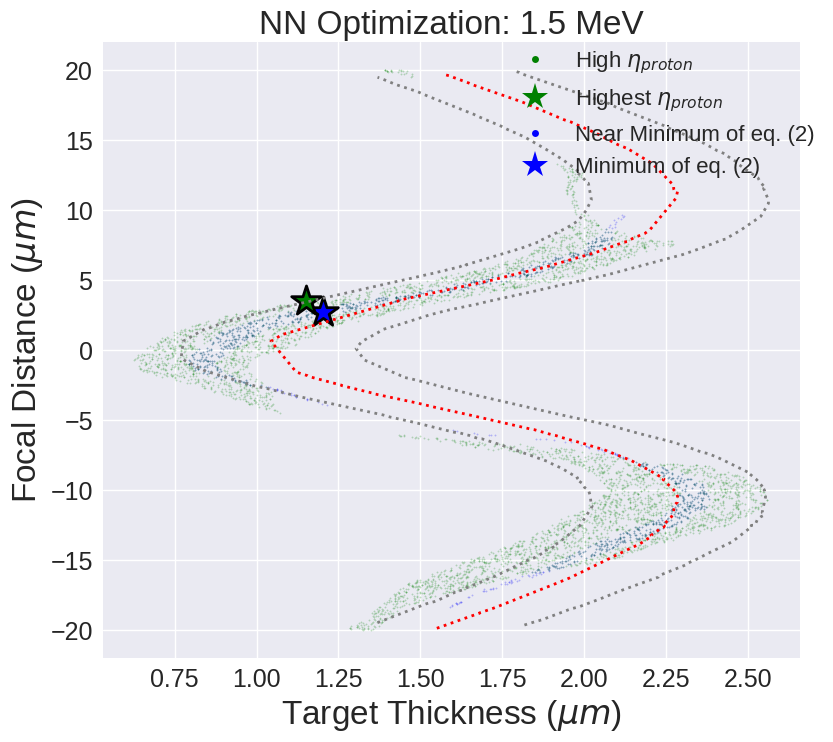

In [14]:
E_cutoffs = [1.5]
etas = [0.25]
thick_xs = [1.3, 4, 6.9]

bounds = [(1e19, 1e19), (0.5, 5.0), (-30.0, 30.0), (1e-7, 1e-7)]
colors = ['blue', 'green', 'red']
threshold = 5 # banana of best points within (threshold) pct of optimal value
tol = 1e-2
border = 0.05
border_width = 1e-3

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))
size1 = 1
size2 = 500

ax.set_xlabel('Target Thickness ($\mu m$)', fontsize=24)
ax.set_ylabel('Focal Distance ($\mu m$)', fontsize=24)
#ax.set_xlim(bounds[1])
#ax.set_ylim(bounds[2])
ax.tick_params(axis='both',  labelsize=18)
ax.set_axisbelow(True)

for i in range(len(E_cutoffs)):
    E_cutoff = E_cutoffs[i]
    η = etas[i]

    fuchs_results_1 = nn_results.copy()
    fuchs_results_1['objective_function'] = fuchs_results_1.apply(objective_function, args=(E_cutoff, η, True, False), axis=1)
    fuchs_results_1.sort_values(by=['objective_function'], ascending=True, inplace=True)
    #print(fuchs_results_1['objective_function'].values)

    fuchs_results_2 = nn_results.copy()
    fuchs_results_2['objective_function'] = fuchs_results_2.apply(objective_function, args=(E_cutoff, η, True, True), axis=1)
    fuchs_results_2.sort_values(by=['objective_function'], ascending=True, inplace=True)

    fuchs_results_3 = fuchs_results.copy()
    fuchs_results_3 = fuchs_results_3.loc[((fuchs_results_3['E Max']-E_cutoff)/E_cutoff < (border + border_width)) & ((fuchs_results_3['E Max']-E_cutoff)/E_cutoff > (border - border_width))]
    fuchs_results_3.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

    fuchs_results_4 = fuchs_results.copy()
    fuchs_results_4 = fuchs_results_4.loc[((fuchs_results_4['E Max']-E_cutoff)/E_cutoff > -1*(border + border_width)) & ((fuchs_results_4['E Max']-E_cutoff)/E_cutoff < (-1*(border - border_width)))]
    fuchs_results_4.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

    fuchs_results_5 = fuchs_results.copy()
    fuchs_results_5 = fuchs_results_5.loc[((fuchs_results_5['E Max']-E_cutoff)/E_cutoff > -1*border_width) & ((fuchs_results_5['E Max']-E_cutoff)/E_cutoff < border_width)]
    fuchs_results_5.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

    ax.plot(fuchs_results_3['Target Thickness'], fuchs_results_3['Focal Distance'], color='gray', linewidth=2, linestyle='dotted', label=f'{E_cutoff} Left')
    ax.plot(fuchs_results_4['Target Thickness'], fuchs_results_4['Focal Distance'], color='gray', linewidth=2, linestyle='dotted', label=f'{E_cutoff} Right')
    ax.plot(fuchs_results_5['Target Thickness'], fuchs_results_5['Focal Distance'], color='red', linewidth=2, linestyle='dotted', label=f'{E_cutoff} Center')
    #print(fuchs_results_3['Target Thickness'].values)
    #print(fuchs_results_4['Target Thickness'].values)
    #print(fuchs_results_5['Target Thickness'].values)

    # np.save('npy_files/fuchs_thickness_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Target Thickness'].values)
    # np.save('npy_files/fuchs_offset_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Focal Distance'].values)
    # np.save('npy_files/fuchs_thickness_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Target Thickness'].values)
    # np.save('npy_files/fuchs_offset_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Focal Distance'].values)
    # np.save('npy_files/fuchs_thickness_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Target Thickness'].values)
    # np.save('npy_files/fuchs_offset_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Focal Distance'].values)
    
    optimal_value_fuchs_1 = fuchs_results_1['objective_function'].iloc[0]
    locations_fuchs_1 = fuchs_results_1.loc[fuchs_results_1['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_1 + tol]
    ax.scatter(locations_fuchs_1['Target Thickness'], locations_fuchs_1['Focal Distance'], color='blue', alpha=0.2, s=size1) 

    optimal_value_fuchs_2 = fuchs_results_2['objective_function'].iloc[0]
    locations_fuchs_2 = fuchs_results_2.loc[fuchs_results_2['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_2 + tol]
    ax.scatter(locations_fuchs_2['Target Thickness'], locations_fuchs_2['Focal Distance'], color='green', alpha=0.2, s=size1)

    ax.scatter(fuchs_results_1['Target Thickness'].iloc[0], fuchs_results_1['Focal Distance'].iloc[0], color='blue', marker='*', s=size2, edgecolor='black', linewidth=2)
    ax.scatter(fuchs_results_2['Target Thickness'].iloc[0], fuchs_results_2['Focal Distance'].iloc[0], color='green', marker='*', s=size2, edgecolor='black', linewidth=2)

    #ax.text(thick_xs[i], -0.7, '$KE_{MeV}$ = ' + '{}'.format(E_cutoff), fontsize=18, color='red')

# ax.text(0.95, 3, '$KE_{MeV}$ = 1.15', fontsize=14, color='gray', rotation=-72)
# ax.text(2.2, 3, '$KE_{MeV}$ = 0.85', fontsize=14, color='gray', rotation=-73)
# ax.text(1.7, 6, '$KE_{MeV}$ = 0.575', fontsize=14, color='gray', rotation=-65)
# ax.text(3.15, 6, '$KE_{MeV}$ = 0.425', fontsize=14, color='gray', rotation=-63)
# ax.text(5.35, 3, '$KE_{MeV}$ = 0.288', fontsize=14, color='gray', rotation=-65)
# ax.text(7.3, 3, '$KE_{MeV}$ = 0.213', fontsize=14, color='gray', rotation=-63)

# Create Line2D instances for the legend
green_patch = mlines.Line2D([], [], color='green', marker='o', markersize=size1*5, label='High $\eta_{proton}$', linestyle='None')
blue_patch = mlines.Line2D([], [], color='blue', marker='o', markersize=size1*5, label='Near Minimum of eq. (2)', linestyle='None')
green_star = mlines.Line2D([], [], color='green', marker='*', markersize=size1*20, label='Highest $\eta_{proton}$', linestyle='None')
blue_star = mlines.Line2D([], [], color='blue', marker='*', markersize=size1*20, label='Minimum of eq. (2)', linestyle='None')

# Add the custom legend to the subplot
ax.legend(handles=[green_patch, green_star, blue_patch, blue_star], bbox_to_anchor=(1.05, 1.02), loc='upper right', fontsize=16)
#ax.legend(loc='best')
ax.set_title(f"NN Optimization: {E_cutoffs[0]} MeV", fontsize=24)


In [6]:
#fig.savefig('plots/fuchs_optim.jpeg', dpi=300, bbox_inches='tight')

In [7]:
# n_points = 10000
# fuchs_results_noise = pd.read_csv('predictions_dfs/fuchs_{}.csv'.format(n_points))

# E_cutoffs = [1, 0.5, 0.25]
# etas = [1, 0.4, 0.175]
# thick_xs = [1, 4, 7]

# bounds = [(1e19, 1e19), (0.0, 10.0), (-1, 10.0)]
# colors = ['blue', 'green', 'red']
# threshold = 5 # banana of best points within (threshold) pct of optimal value
# tol = 1e-2
# j=0 # noise level
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))
# size1 = 10
# size2 = 500
# alpha = 1

# ax.set_xlabel('Target Thickness ($\mu m$)', fontsize=24)
# ax.set_ylabel('Focal Distance ($\mu m$)', fontsize=24)
# ax.set_xlim(bounds[1])
# ax.set_ylim(bounds[2])
# ax.tick_params(axis='both',  labelsize=18)
# ax.set_axisbelow(True)

# for i in range(len(E_cutoffs)):
#     E_cutoff = E_cutoffs[i]
#     η = etas[i]

#     fuchs_results_1 = fuchs_results_noise.copy()
#     fuchs_results_1['objective_function'] = fuchs_results_1.apply(objective_function, args=(E_cutoff, η, True, False), axis=1)
#     fuchs_results_1.sort_values(by=['objective_function'], ascending=True, inplace=True)

#     fuchs_results_2 = fuchs_results_noise.copy()
#     fuchs_results_2['objective_function'] = fuchs_results_2.apply(objective_function, args=(E_cutoff, η, True, True), axis=1)
#     fuchs_results_2.sort_values(by=['objective_function'], ascending=True, inplace=True)


#     fuchs_results_3 = fuchs_results.copy()
#     fuchs_results_3 = fuchs_results_3.loc[((fuchs_results_3['E Max']-E_cutoff)/E_cutoff < 0.151) & ((fuchs_results_3['E Max']-E_cutoff)/E_cutoff > 0.149)]
#     fuchs_results_3.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

#     fuchs_results_4 = fuchs_results.copy()
#     fuchs_results_4 = fuchs_results_4.loc[((fuchs_results_4['E Max']-E_cutoff)/E_cutoff > -0.151) & ((fuchs_results_4['E Max']-E_cutoff)/E_cutoff < -0.149)]
#     fuchs_results_4.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

#     fuchs_results_5 = fuchs_results.copy()
#     fuchs_results_5 = fuchs_results_5.loc[((fuchs_results_5['E Max']-E_cutoff)/E_cutoff > -0.001) & ((fuchs_results_5['E Max']-E_cutoff)/E_cutoff < 0.001)]
#     fuchs_results_5.sort_values(by=['Focal Distance'], ascending=True, inplace=True)

#     ax.plot(fuchs_results_3['Target Thickness'], fuchs_results_3['Focal Distance'], color='gray', linewidth=2, linestyle='dotted')
#     ax.plot(fuchs_results_4['Target Thickness'], fuchs_results_4['Focal Distance'], color='gray', linewidth=2, linestyle='dotted')
#     ax.plot(fuchs_results_5['Target Thickness'], fuchs_results_5['Focal Distance'], color='red', linewidth=2, linestyle='dotted')

# #     np.save('npy_files/fuchs_thickness_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Target Thickness'].values)
# #     np.save('npy_files/fuchs_offset_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Focal Distance'].values)
# #     np.save('npy_files/fuchs_thickness_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Target Thickness'].values)
# #     np.save('npy_files/fuchs_offset_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Focal Distance'].values)
# #     np.save('npy_files/fuchs_thickness_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Target Thickness'].values)
# #     np.save('npy_files/fuchs_offset_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Focal Distance'].values)
    
#     optimal_value_fuchs_1 = fuchs_results_1['objective_function'].iloc[0]
#     locations_fuchs_1 = fuchs_results_1.loc[fuchs_results_1['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_1 + tol]
#     ax.scatter(locations_fuchs_1['Target Thickness'], locations_fuchs_1['Focal Distance'], label='Mix', color='blue', alpha=alpha, s=size1) 

#     optimal_value_fuchs_2 = fuchs_results_2['objective_function'].iloc[0]
#     locations_fuchs_2 = fuchs_results_2.loc[fuchs_results_2['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_2 + tol]
#     ax.scatter(locations_fuchs_2['Target Thickness'], locations_fuchs_2['Focal Distance'], label='Max Efficiency', color='green', alpha=alpha, s=size1)

#     ax.scatter(fuchs_results_1['Target Thickness'].iloc[0], fuchs_results_1['Focal Distance'].iloc[0], color='blue', marker='*', s=size2, edgecolor='black', linewidth=2)
#     ax.scatter(fuchs_results_2['Target Thickness'].iloc[0], fuchs_results_2['Focal Distance'].iloc[0], color='green', marker='*', s=size2, edgecolor='black', linewidth=2)

#     ax.text(thick_xs[i], -0.8, '$KE_{MeV}$ = ' + '{}'.format(E_cutoff), fontsize=20)
# #ax.legend()
# #ax.text(0.5, 0.5, 'Noise = {}'.format(noises[j]), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)

In [8]:
#fig.savefig('plots/fuchs_optim_{}.jpeg'.format(n_points), dpi=300, bbox_inches='tight')

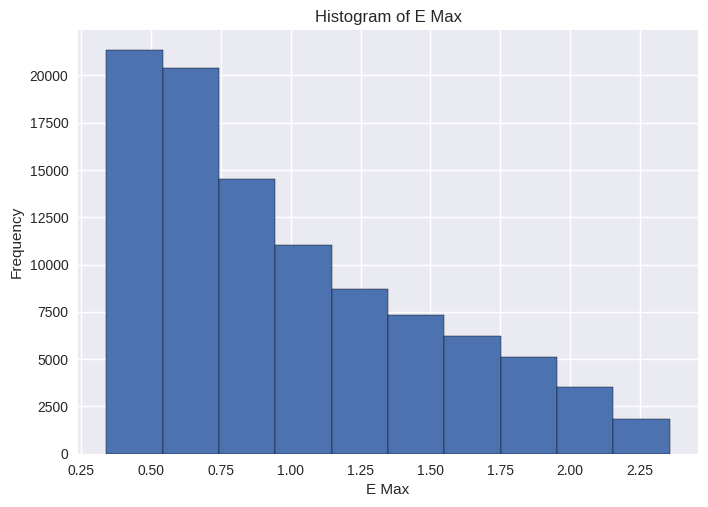

In [9]:
# Assuming fuchs_results['E Max'] is a list or a pandas Series
data = fuchs_results['E Max']

plt.hist(data, bins=10, edgecolor='black')
plt.title('Histogram of E Max')
plt.xlabel('E Max')
plt.ylabel('Frequency')
plt.show()

In [10]:
fuchs_results_1.head(100)

,Intensity,Target Thickness,Focal Distance,Contrast,E Max,E Tot,E Avg,objective_function
20587,1.000000e+19,3.155493,8.492296,1.000000e-07,1.250760,1.420066e+09,0.182726,0.070063
45371,1.000000e+19,3.139298,8.653337,1.000000e-07,1.250694,1.418598e+09,0.182282,0.070095
7403,1.000000e+19,3.113031,8.986179,1.000000e-07,1.249515,1.410695e+09,0.181152,0.070360
44501,1.000000e+19,3.113837,8.909549,1.000000e-07,1.250867,1.414438e+09,0.181515,0.070404
70115,1.000000e+19,3.085269,9.230058,1.000000e-07,1.250406,1.408045e+09,0.180495,0.070444
...,...,...,...,...,...,...,...,...
4394,1.000000e+19,3.166144,-9.931104,1.000000e-07,1.250131,1.351948e+09,0.175737,0.073192
65839,1.000000e+19,2.523514,-4.187388,1.000000e-07,1.249168,1.359694e+09,0.187675,0.073197
96896,1.000000e+19,3.150329,-11.813193,1.000000e-07,1.249132,1.360049e+09,0.169908,0.073199
89714,1.000000e+19,2.155357,-2.142792,1.000000e-07,1.253011,1.384424e+09,0.188911,0.073205
